In [1]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 

# Closure Simulations

The purpose of this simulation is to see if a lack of redundancy in the telescope can cause a similar effect to what I see in the HERA data.

We will start by generating some electric fields at locations that correspond to a HERA-like layout. We will use a gaussian beam first, then switch to using a different beam for each telescope and see what happens.

Then we will look at different sky layouts and how that shakes things up.

In [2]:
# For simulating Electric Fields
def simulate_electric_fields(locations_uvw,points):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    
    for i in numpy.arange(locations_uvw.shape[0]):
        for point in points:
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            amp = point[2]
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += amp*numpy.exp(2j*numpy.pi*(u*l+v*m+w*n))
    return elec_ss

# 7 Antennas
def generate_hera_layout_simple():
    layout_vec = numpy.zeros(shape=(14,3))
    
    
    layout_vec[0] = numpy.asarray([-7,24.2486,0])
    layout_vec[1] = numpy.asarray([7,24.2486,0])
    layout_vec[2] = numpy.asarray([-14,12.1243,0])
    layout_vec[3] = numpy.asarray([0,12.1243,0])
    layout_vec[4] = numpy.asarray([14,12.1243,0])
    layout_vec[5] = numpy.asarray([-21,0,0])
    layout_vec[6] = numpy.asarray([-7,0,0])
    layout_vec[7] = numpy.asarray([7,0,0])
    layout_vec[8] = numpy.asarray([21,0,0])
    layout_vec[9] = numpy.asarray([-14,-12.1243,0])
    layout_vec[10] = numpy.asarray([0,-12.1243,0])
    layout_vec[11] = numpy.asarray([14,-12.1243,0])
    layout_vec[12] = numpy.asarray([-7,-24.2486,0])
    layout_vec[13] = numpy.asarray([7,-24.2486,0])

    
    
    return layout_vec

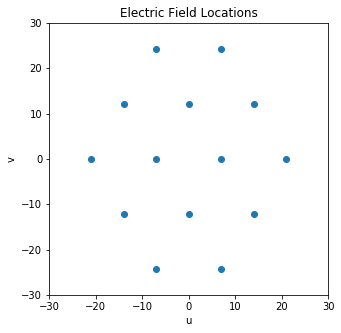

In [3]:
locs = generate_hera_layout_simple()
us = locs[:,0]
vs = locs[:,1]
ws = locs[:,2]
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(us,vs)
ax.set_title('Electric Field Locations')
ax.set_xlim([-30,30])
ax.set_ylim([-30,30])
ax.set_xlabel('u'); ax.set_ylabel('v');# ax.set_zlabel('v'); 

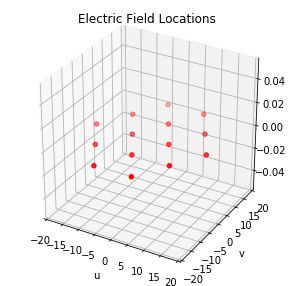

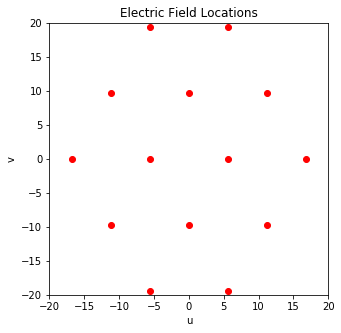

In [4]:
frequency = 120e6 # Let's just do this in a single channel for now.
chan_bw = 25e3

wavelength = 3e8 / frequency

locs_uvw = locs/(wavelength/2)

us_uvw = locs_uvw[:,0]
vs_uvw = locs_uvw[:,1]
ws_uvw = locs_uvw[:,2]

fig, ax = plt.subplots(figsize=(5,5),subplot_kw={'projection': '3d'})
ax.scatter(us_uvw,vs_uvw,ws_uvw,color='red')
ax.set_title('Electric Field Locations')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_xlabel('u'); ax.set_ylabel('v');
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(us_uvw,vs_uvw,color='red')
ax.set_title('Electric Field Locations')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_xlabel('u'); ax.set_ylabel('v');
plt.show()

Now let's try and generate some sort of beam to work with.

(2000,)


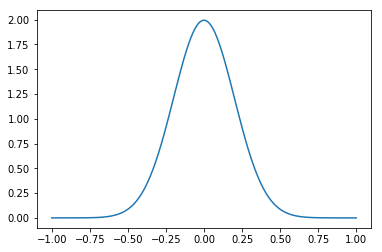

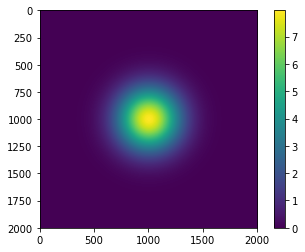

In [53]:
from scipy.stats import norm
def generate_gaussian_beam():
    x = numpy.linspace(-1,1,2000)
    return x,norm.pdf(x, loc=0, scale=0.2) + 1j*norm.pdf(x, loc=0,scale=0.2)

def find_beam_at_point(beam,point):
    beam_shape = beam.shape[0]
    
    pl = point[0]
    pm = point[1]
    
    step = 2/beam_shape
    
    bl_ind = int((pl + 1)/step)
    bm_ind = int((pm + 1)/step)
    
    return beam[bl_ind] * beam[bm_ind]

    
angle, beam = generate_gaussian_beam()
print(angle.shape)
plt.plot(angle, beam)
plt.show()

# 2D one too

beam_2D = numpy.outer(beam,beam.T.conj())
plt.imshow(beam_2D.real)
plt.colorbar()
plt.show()

In [54]:
# For simulating Electric Fields
def simulate_electric_fields_gaussianbeam(locations_uvw,points,beam):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    phase_source = numpy.zeros(shape=(points.shape[0]),dtype=numpy.complex128)
    print(phase_source.shape)
    for i in numpy.arange(points.shape[0]):
        phase_source[i] = numpy.exp(1j*numpy.random.uniform(0,2*numpy.pi))
    
    for i in numpy.arange(locations_uvw.shape[0]):
        #print(locations_uvw[i,:])
        #numpy.random.seed(12345)
        antenna_noise = 5000*(numpy.random.normal(scale=4000.0) + 1j * numpy.random.normal(scale=4000.0))
        #antenna_noise = 0
        
        for j,point in enumerate(points):
            #print(j)
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += point[2]*numpy.exp(2j*numpy.pi*(u*l+v*m+w*n)) * numpy.random.uniform(0.9,1.1) * find_beam_at_point(beam,point) * phase_source[j]
        elec_ss[i] += antenna_noise
    return elec_ss

In [68]:
points = [[0.2,0.2,100],[0.05,0.3,40],[-0.45,0.45,100],[0.45,0.45,100],[0.45,-0.45,100],
          [-0.45,-0.45,100],[0.5,0.0,100],[0.0,0.5,100],[-0.5,0.0,100],[-0.5,-0.5,100],
          [-0.8,0.0,100],[0.8,0.0,100],[0.21,0.21,100],[0.205,0.205,100]]
#points = [[0.0,0.0,1],[0.48,0.49,4],[0.47,0.49,4],[0.48,0.48,4]]
efields = simulate_electric_fields_gaussianbeam(locs_uvw,numpy.asarray(points),beam)

(14,)


In [69]:
print(efields)
print(locs_uvw)

[ -2568831.92544443-18986720.97488977j
 -11098970.07720821 -4844589.31483297j
   7759971.88408777 +3175961.87204678j
 -23617900.73885181 -6207933.6213835j
 -42408377.67458919-13617501.85810966j
 -37753153.98473531 -8918754.08436123j
  -3267652.81714699 +7851702.86072951j
 -54678986.47318589+10449738.90199587j
 -12787201.87924377 -9082543.94347486j
  13461649.31582955+14069998.88951404j
  45655960.83032825+33034655.59599824j
 -14088884.96629709+45352501.75976103j
  13959551.76659541+11221162.07632182j
  -4556343.48116982+14441304.45593835j]
[[ -5.6      19.39888   0.     ]
 [  5.6      19.39888   0.     ]
 [-11.2       9.69944   0.     ]
 [  0.        9.69944   0.     ]
 [ 11.2       9.69944   0.     ]
 [-16.8       0.        0.     ]
 [ -5.6       0.        0.     ]
 [  5.6       0.        0.     ]
 [ 16.8       0.        0.     ]
 [-11.2      -9.69944   0.     ]
 [  0.       -9.69944   0.     ]
 [ 11.2      -9.69944   0.     ]
 [ -5.6     -19.39888   0.     ]
 [  5.6     -19.39888   0

DFT Sky to see what it looks like

In [70]:
def epic_image_dft(theta,lam,efield,locations):
    grid_size = int(theta*lam)
    image = numpy.zeros(shape=(grid_size,grid_size),dtype=numpy.complex128)
    
    for lg in numpy.arange(grid_size):
        
        lv = (1.0 / (0.5*grid_size)) * (lg - grid_size/2)
        #print(lv)
        for mg in numpy.arange(grid_size):
            mv = (1.0/ (0.5*grid_size)) * (mg - grid_size/2)
            if (lv**2 + mv**2 > 1.0):
                nv = 0
            else:
                nv = 1.0 - numpy.sqrt(1.0 - lv**2 - mv**2)
            #print(nv)
            for j,efieldd in enumerate(efield):
                u = locations[j,0]
                v = locations[j,1]
                w = locations[j,2]
                #w = 0
                image[lg,mg] += efieldd * numpy.exp(2j*numpy.pi*(u*lv + v*mv + w*nv))
    return image / (grid_size**2)

In [71]:
image = epic_image_dft(2,32,efields,locs_uvw)

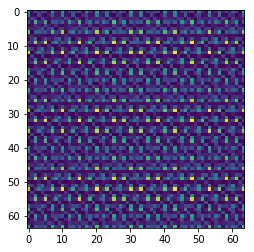

In [72]:
plt.imshow((image * image.conj()).real)
plt.show()

Dreadful but expected considering HERA's PSF is rubbish.

## Visibilities

Let's start making some visibilities up

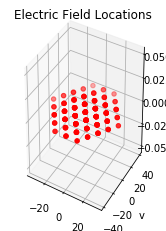

In [73]:
visibilities = numpy.outer(efields,efields.T.conj())

def generate_baseline_vectors(locations):
    
    loc_no = locations.shape[0]
    baseline_vectors = numpy.zeros(shape=(loc_no, loc_no,3))
    
    for i in numpy.arange(loc_no):
        for j in numpy.arange(loc_no):
            baseline_vectors[i,j,0] = (locations[i,0] - locations[j,0])#/2
            baseline_vectors[i,j,1] = (locations[i,1] - locations[j,1])#/2
            baseline_vectors[i,j,2] = (locations[i,2] - locations[j,2])#/2
            
    return baseline_vectors


def plot_baselines(baselines):
    
    us = baselines[:,:,0]
    vs = baselines[:,:,1]
    ws = baselines[:,:,2]
    ax = plt.subplot(121, projection='3d')
    ax.scatter(us,vs,ws, color='red')
    ax.set_title('Electric Field Locations')
    ax.set_xlabel('u'); ax.set_ylabel('v'); ax.set_zlabel('w')
    plt.show()
    

baselines = generate_baseline_vectors(locs_uvw)
plot_baselines(baselines)

In [74]:
baselines_ew_14m = numpy.asarray([[0,1],[2,3],[3,4],[5,6]])
visibilities_ew_14m = visibilities[baselines_ew_14m[:,0],baselines_ew_14m[:,1]]
print(visibilities)

[[ 3.67094471e+14+0.00000000e+00j  1.20494254e+14+1.98288112e+14j
  -8.02351654e+13-1.39177909e+14j  1.78538721e+14+4.32479353e+14j
   3.67491703e+14+7.70214960e+14j  2.66319402e+14+6.93897820e+14j
  -1.40684041e+14+8.22117173e+13j -5.79451507e+13+1.06501828e+15j
   2.05295900e+14+2.19455505e+14j -3.01723858e+14-2.19449117e+14j
  -7.44502278e+14-7.81996511e+14j -8.24903319e+14+3.84004682e+14j
  -2.48912816e+14-2.36220835e+14j -2.62488538e+14+1.23607306e+14j]
 [ 1.20494254e+14-1.98288112e+14j  1.46657182e+14+0.00000000e+00j
  -1.01513927e+14-2.34397109e+12j  2.92209262e+14+4.55173601e+13j
   5.36660519e+14+5.43109277e+13j  4.62228827e+14+8.39095417e+13j
  -1.77069494e+12+1.02976251e+14j  5.56255741e+14+3.80878573e+14j
   1.85925966e+14-3.88581419e+13j -2.17573809e+14+9.09463342e+13j
  -6.66773483e+14+1.45466274e+14j -6.33421328e+13+5.71620922e+14j
  -2.09298569e+14+5.69150468e+13j -1.93914693e+13+1.82357219e+14j]
 [-8.02351654e+13+1.39177909e+14j -1.01513927e+14+2.34397109e+12j
   7.030

In [75]:
print(numpy.abs(visibilities))

[[3.67094471e+14 2.32028103e+14 1.60649220e+14 4.67882962e+14
  8.53393952e+14 7.43249762e+14 1.62944057e+14 1.06659345e+15
  3.00511440e+14 3.73088731e+14 1.07972320e+15 9.09903886e+14
  3.43158670e+14 2.90136172e+14]
 [2.32028103e+14 1.46657182e+14 1.01540984e+14 2.95733128e+14
  5.39401696e+14 4.69783248e+14 1.02991474e+14 6.74157947e+14
  1.89943202e+14 2.35816874e+14 6.82456822e+14 5.75119730e+14
  2.16899086e+14 1.83385344e+14]
 [1.60649220e+14 1.01540984e+14 7.03038975e+13 2.04756647e+14
  3.73465372e+14 3.25263670e+14 7.13081722e+13 4.66766512e+14
  1.31510912e+14 1.63272450e+14 4.72512402e+14 3.98195455e+14
  1.50174348e+14 1.26970449e+14]
 [4.67882962e+14 2.95733128e+14 2.04756647e+14 5.96343675e+14
  1.08769955e+15 9.47314459e+14 2.07681548e+14 1.35943453e+15
  3.83019069e+14 4.75522990e+14 1.37616916e+15 1.15972470e+15
  4.37375410e+14 3.69795196e+14]
 [8.53393952e+14 5.39401696e+14 3.73465372e+14 1.08769955e+15
  1.98390685e+15 1.72785183e+15 3.78800237e+14 2.47953720e+15


## Closure Phases

Closure phases can be generated by multipling three visibilities from a set of baselines comprising three antennas in a closed geometric triangle.

The phase of the resulting complex number is taken and provides our closure phase for each 'triad'

Should do as Bojan does and just give each antenna an id, in this case comensurate with its position in the array and extract the baselines I care about. 



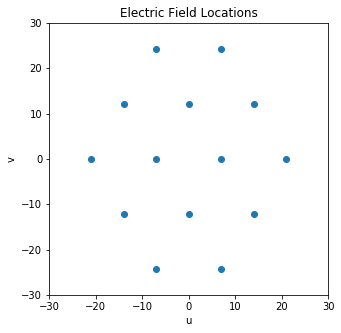

In [76]:
us = locs[:,0]
vs = locs[:,1]
ws = locs[:,2]
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(us,vs)
ax.set_title('Electric Field Locations')
ax.set_xlim([-30,30])
ax.set_ylim([-30,30])
ax.set_xlabel('u'); ax.set_ylabel('v');# ax.set_zlabel('v'); 

In [77]:
List_of_antennas = [[[0,2],[2,3],[3,0]],
                    [[1,3],[3,4],[4,1]],
                    [[2,5],[5,6],[6,2]],
                    [[3,6],[6,7],[7,3]],
                    [[6,9],[9,10],[10,6]],
                    [[7,10],[10,11],[11,7]],
                    [[10,12],[12,13],[13,10]]]

In [78]:
def generate_closure_triads(visb,antenna_list):
    
    ant_list = numpy.asarray(antenna_list)
    triads = numpy.zeros(shape=ant_list.shape[0])
    for i,triadconfig in enumerate(ant_list):
        vis1l = triadconfig[0]
        vis2l = triadconfig[1]
        vis3l = triadconfig[2]
        #print(triadconfig)
        vis1 = numpy.angle(visb[vis1l[0],vis1l[1]])
        vis2 = numpy.angle(visb[vis2l[0],vis2l[1]])
        vis3 = numpy.angle(visb[vis3l[0],vis3l[1]])
        print(vis1,vis2,vis3)
        triads[i] = vis1 + vis2 + vis3
        
    return triads

In [79]:
closures = generate_closure_triads(visibilities,List_of_antennas)

-2.0937523178878545 -3.0101508037697235 -1.1792821855220084
0.15452789064268477 -0.05366963201990719 -0.1008582586227776
-2.985101775482701 1.4084128912086145 1.5766888842740867
1.4334619194956368 -0.9875937105890248 -0.4458682089066122
1.157674281390777 0.18112973515663328 -1.3388040165474102
2.326397727136435 -1.2456363131251151 -1.08076141401132
-0.050713161201068176 -1.1993446333384796 1.2500577945395477


In [80]:
closures

array([-6.28318531e+00, -1.38777878e-17,  2.22044605e-16, -1.66533454e-16,
        0.00000000e+00,  0.00000000e+00, -2.22044605e-16])

Zero closures? Seems suspicious. Let's try screwing up the beam shapes and see what happens.
Let's make a different gaussian beam for each antenna and see what happens.

In [81]:
def generate_beam_per_antenna(locs):
    beams_matrix = numpy.zeros(shape=(locs.shape[0],2000),dtype=numpy.complex128)
    
    x = numpy.linspace(-1,1,2000)
    
    for i in numpy.arange(locs.shape[0]):

        beamr = norm.pdf(x, loc=0, scale=numpy.random.uniform(0.0001,0.5))
        beamp = norm.pdf(x, loc=0, scale=numpy.random.uniform(0.0001,0.5))
        beams_matrix[i,:] = beamr * numpy.exp(1j * beamp)
        plt.plot(x, beamr)
        plt.show()
    
    return x,beams_matrix

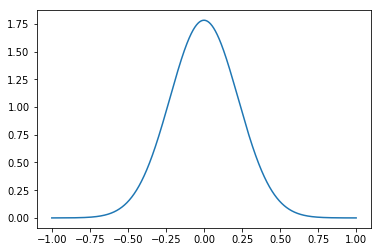

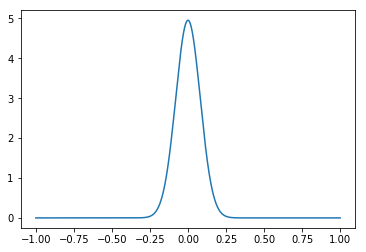

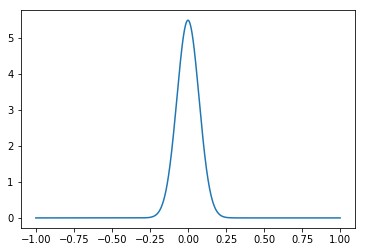

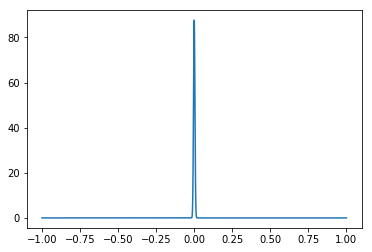

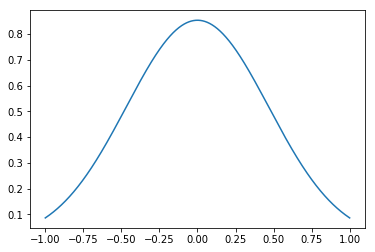

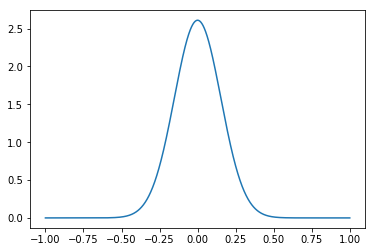

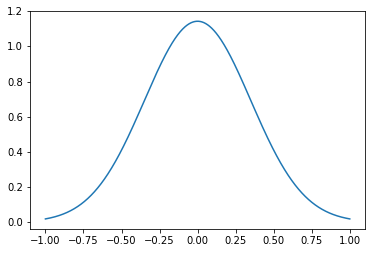

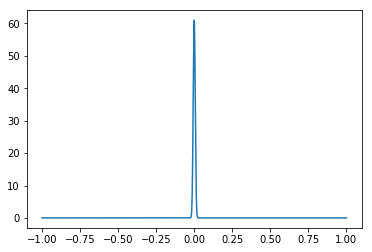

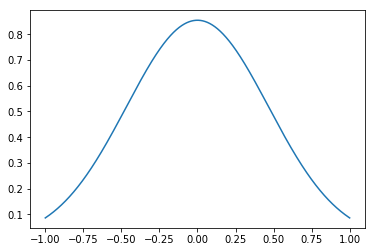

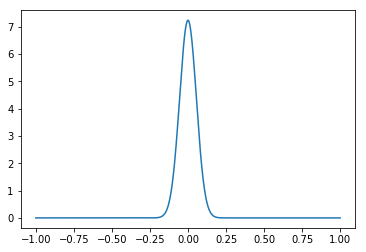

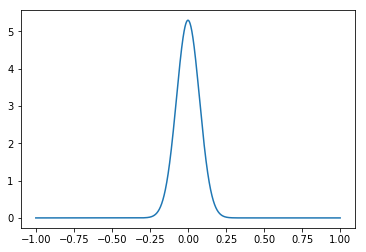

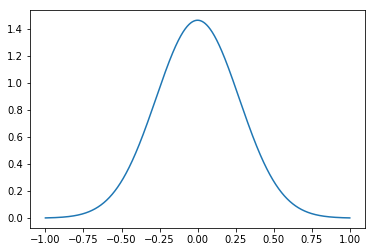

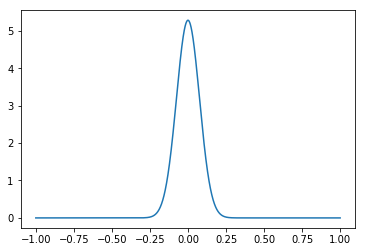

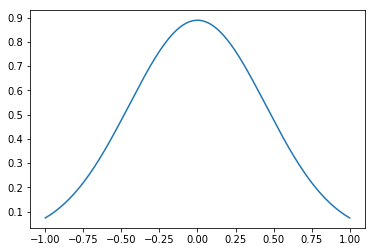

In [82]:
x,beams = generate_beam_per_antenna(locs)

In [83]:
print(beams[2])

[4.79252327e-41+3.21280686e-64j 5.79003983e-41+4.33102638e-64j
 6.99385580e-41+5.83669774e-64j ... 6.99385580e-41+5.83669774e-64j
 5.79003983e-41+4.33102638e-64j 4.79252327e-41+3.21280686e-64j]


In [84]:
# For simulating Electric Fields
def simulate_electric_fields_different_beams(locations_uvw,points,beam_matrices):
    elec_ss = numpy.zeros(shape=(locations_uvw.shape[0]),dtype=numpy.complex128)
    
    phase_source = numpy.zeros(shape=(points.shape[0]),dtype=numpy.complex128)
    print(phase_source.shape)
    for i in numpy.arange(points.shape[0]):
        phase_source[i] = numpy.exp(1j*numpy.random.uniform(0,2*numpy.pi))
    
    for i in numpy.arange(locations_uvw.shape[0]):
        
        antenna_noise = numpy.random.normal(scale=4000.0)# + 1j * numpy.random.normal(scale=2000.0)
        for j,point in enumerate(points):
            noisep_cont = numpy.exp(1j*numpy.random.uniform(0,2*numpy.pi))
            noisea_cont = numpy.random.uniform(0,point[2]/2)
            l = point[0]
            m = point[1]
            n = numpy.sqrt(1.0-l**2-m**2) - 1.0
            bap = find_beam_at_point(beam_matrices[i,:],point)
            print(bap)
            amp = point[2]
            #print(amp)
            u = locations_uvw[i,0]
            v = locations_uvw[i,1]
            w = locations_uvw[i,2]
            elec_ss[i] += amp*numpy.exp(2j*numpy.pi*(u*l+v*m+w*n)) * bap * phase_source[j]
        elec_ss[i] += antenna_noise
    return elec_ss

In [85]:
efields_db = simulate_electric_fields_different_beams(locs_uvw,numpy.asarray(points),beams)
print(efields_db)
print(points)
print(efields)

(14,)
(-1.0435838911606328+0.9676011187993654j)
(-0.99215938513184+0.7710321467545271j)
(0.05001754349904347+0.023796058381853502j)
(0.04961818510201736+0.023479967718681223j)
(0.05001754349904347+0.023796058381853502j)
(0.05041985013858202+0.024115842091873896j)
(-0.09655142780245632+0.24107724482741164j)
(-0.09655142780245632+0.24107724482741164j)
(-0.09786451696010329+0.24336276545215857j)
(0.020836279635161388+0.005825406988934535j)
(-0.001288058992035181+0.005078710163657759j)
(-0.0012880589920351857+0.005078710163657778j)
(-0.867462049769259+0.9827389950215821j)
(-0.9544519456527376+0.977943764620024j)
(0.022695719138339714+0.04421456418820703j)
(-0.017576606770885423-0.0072773376825088516j)
(6.647966300680658e-13+2.506921823993195e-16j)
(6.202118016551766e-13+2.287084801174655e-16j)
(6.647966300680658e-13+2.506921823993195e-16j)
(7.125865037390114e-13+2.7465465734444756e-16j)
(-6.857080246647474e-08-7.222793622207877e-08j)
(-6.857080246647474e-08-7.222793622207877e-08j)
(-7.4069

In [86]:
visibilities_db = numpy.outer(efields_db,efields_db.T.conj()) 
print(visibilities_db)
#visibilities_db = visibilities_db + 50000*(numpy.random.randn(visibilities_db.shape[0],visibilities_db.shape[1]) + 1j*numpy.random.randn(visibilities_db.shape[0],visibilities_db.shape[1]))

[[ 1.15352732e+08+0.00000000e+00j  1.46741941e+08+7.01023186e+04j
  -4.71220708e+07-3.36547827e+04j  2.94116830e+07+1.46934604e+04j
  -2.47258204e+07+1.26778756e+04j  6.59468092e+07-6.11648825e+05j
  -1.40656017e+07-4.25596713e+05j  2.75420892e+06+1.37594505e+03j
  -5.19076637e+07-7.63737156e+03j -1.35814990e+07-6.85075704e+03j
  -3.91827033e+07-9.43611887e+03j  2.26655276e+07-6.25518328e+05j
  -1.77739582e+06+1.27165365e+04j  3.57076902e+07+6.26504852e+05j]
 [ 1.46741941e+08-7.01023186e+04j  1.86672666e+08+0.00000000e+00j
  -5.99447132e+07-1.41756651e+04j  3.74150518e+07+8.17663525e+02j
  -3.14540792e+07+3.11541246e+04j  8.38915532e+07-8.18164925e+05j
  -1.78933215e+07-5.32859994e+05j  3.50367130e+06+7.65687627e+01j
  -6.60325219e+07+2.18297807e+04j -1.72772327e+07-4.61183813e+02j
  -4.98449102e+07+1.18083372e+04j  2.88327774e+07-8.09505570e+05j
  -2.26104415e+06+1.72570582e+04j  4.54246688e+07+7.75285890e+05j]
 [-4.71220708e+07+3.36547827e+04j -5.99447132e+07+1.41756651e+04j
   1.924

In [87]:
closures_db = generate_closure_triads(visibilities_db,List_of_antennas)

-3.1408784494723205 3.141378028472443 -0.0004995790001221877
2.1853865873978084e-05 3.1405803363159888 -3.1406021901818626
3.131603834157414 -3.1020692861710337 -0.029534547986380204
-3.111843480486063 3.111843480486063 0.0
-0.029744333816799542 -0.0002635947123087249 0.030007928529108267
3.1413338981644157 3.113761049618637 0.02809035939653386
-0.007395290454148669 -3.1168946107335302 3.124289901187679


In [88]:
print(visibilities_db)
print(closures_db)

[[ 1.15352732e+08+0.00000000e+00j  1.46741941e+08+7.01023186e+04j
  -4.71220708e+07-3.36547827e+04j  2.94116830e+07+1.46934604e+04j
  -2.47258204e+07+1.26778756e+04j  6.59468092e+07-6.11648825e+05j
  -1.40656017e+07-4.25596713e+05j  2.75420892e+06+1.37594505e+03j
  -5.19076637e+07-7.63737156e+03j -1.35814990e+07-6.85075704e+03j
  -3.91827033e+07-9.43611887e+03j  2.26655276e+07-6.25518328e+05j
  -1.77739582e+06+1.27165365e+04j  3.57076902e+07+6.26504852e+05j]
 [ 1.46741941e+08-7.01023186e+04j  1.86672666e+08+0.00000000e+00j
  -5.99447132e+07-1.41756651e+04j  3.74150518e+07+8.17663525e+02j
  -3.14540792e+07+3.11541246e+04j  8.38915532e+07-8.18164925e+05j
  -1.78933215e+07-5.32859994e+05j  3.50367130e+06+7.65687627e+01j
  -6.60325219e+07+2.18297807e+04j -1.72772327e+07-4.61183813e+02j
  -4.98449102e+07+1.18083372e+04j  2.88327774e+07-8.09505570e+05j
  -2.26104415e+06+1.72570582e+04j  4.54246688e+07+7.75285890e+05j]
 [-4.71220708e+07+3.36547827e+04j -5.99447132e+07+1.41756651e+04j
   1.924

# This makes sense as I have only added direction-independent noise apart from each sources own phase. 

Why different beam shapes doesn't break closure is very difficult for me to get my head around though.